In [1]:
### Load packages

%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

In [2]:
### Define environment variables

HOMEDIR = os.environ["HOME"]

BASEDIR = os.path.join(HOMEDIR, "workspace", "self_education", "udacity", "TensorFlowUdacity")

DATADIR = os.path.join(BASEDIR, "data")
TRAINDATADIR = os.path.join(DATADIR, "notmnist", "notmnist_large")
TESTDATADIR = os.path.join(DATADIR, "notmnist", "notmnist_small")

In [3]:
### Functions for getting array of directory paths and array of file paths

def get_dir_paths(root):
  return [os.path.join(root, n) for n in sorted(os.listdir(root)) if os.path.isdir(os.path.join(root, n))]

def get_file_paths(root):
  return [os.path.join(root, n) for n in sorted(os.listdir(root)) if os.path.isfile(os.path.join(root, n))]

In [4]:
### Get directory and file paths of training and test sets

train_data_paths = get_dir_paths(TRAINDATADIR)
test_data_paths = get_dir_paths(TESTDATADIR)

### Problem 1

In [5]:
## Display a sample of 5 images in their initial png format

nsamples = 5

for i in np.arange(nsamples):
  display(Image(filename=np.random.choice(get_file_paths(np.random.choice(test_data_paths)))))

In [6]:
## Set image properties

image_size = 28 # Pixel width and height
pixel_depth = 255.0  # Number of levels per pixel

In [7]:
## Read a sample image

image_file = np.random.choice(get_file_paths(np.random.choice(test_data_paths)))
image_data = ndimage.imread(image_file).astype(float)

In [8]:
## Show type of image object

type(image_data)

numpy.ndarray

In [9]:
## Show dimensions of image object

image_data.shape

(28, 28)

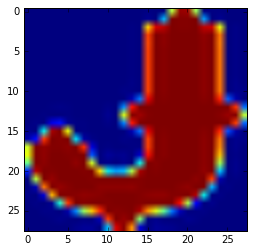

In [10]:
## Plot image using imshow

plt.imshow(image_data)
plt.show()
# display(Image(image_data))

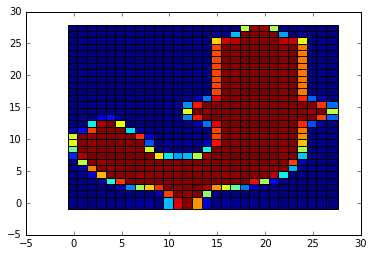

In [11]:
## Plot image using a scatterplot

colors = [str(i/pixel_depth) for i in np.ravel(image_data)]
plt.scatter(
  np.tile(np.arange(image_size), image_size),
  np.repeat(np.flipud(np.arange(image_size)), image_size),
  s=150,
  c=colors,
  marker='s'
)
plt.show()

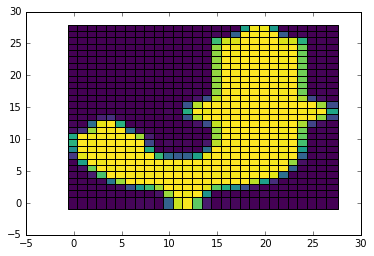

In [12]:
## Plot image using a scatterplot by setting cmap option

colors = [str(i/pixel_depth) for i in np.ravel(image_data)]
plt.scatter(
  np.tile(np.arange(image_size), image_size),
  np.repeat(np.flipud(np.arange(image_size)), image_size),
  s=150,
  c=colors,
  marker='s',
  cmap=plt.cm.viridis    
)
plt.show()

In [13]:
## Function for loading data for a single letter

def load_letter(root, image_size, pixel_depth, verbose=True, min_nimages=1):
  """Load data for a single letter."""

  if verbose:
        print(root)

  image_files = get_file_paths(root)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size), dtype=np.float32)

  image_index = 0
  for image in image_files:
    try:
      image_data = (ndimage.imread(image).astype(float)-pixel_depth/2)/pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[image_index, :, :] = image_data
      image_index += 1
    except IOError as e:
      print('Skipping because of not being able to read: ', image_file)

  dataset = dataset[0:image_index, :, :]
  if image_index < min_nimages:
    raise Exception('Fewer images than expected: %d < %d' % (image_index, min_nimages))

  if verbose:    
    print('Full dataset tensor: ', dataset.shape)
    print('Mean: ', np.mean(dataset))
    print('Standard deviation: ', np.std(dataset))

  return dataset

In [14]:
## Test load_letter() function by loading data for letter C

letter_data = load_letter(test_data_paths[2], image_size, pixel_depth)

/Users/theodore/workspace/self_education/udacity/TensorFlowUdacity/data/notmnist/notmnist_small/C
('Full dataset tensor: ', (1873, 28, 28))
('Mean: ', -0.14152053)
('Standard deviation: ', 0.44269028)


In [15]:
## Show dimensions of loaded data for letter C

letter_data.shape

(1873, 28, 28)

In [16]:
## Show dimensions of data for the first image of letter C

letter_data[0, :, :].shape

(28, 28)

In [17]:
## Function for generating pickle filenames

def generate_pickle_names(root):
  dataset_files = []

  for d in root:
    pickle_file = d + '.pickle'
    dataset_files.append(pickle_file)
  
  return dataset_files

In [18]:
## Function for pickling data of all letters

def pickle_letters(root, image_size, pixel_depth, verbose=True, min_nimages=1, force=False):
  pickle_files = generate_pickle_names(root)
  n = len(root)
    
  for i in np.arange(n):
    if os.path.exists(pickle_files[i]) and not force:
      print('%s already present, skipping pickling' % pickle_files[i])
    else:
      print('Pickling %s' % pickle_files[i])
      dataset = load_letter(root[i], image_size, pixel_depth, verbose=verbose, min_nimages=min_nimages)
      try:
        with open(pickle_files[i], 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', pickle_files[i], ':', e)
  
  return pickle_files

In [19]:
### Pickle training set

train_files = pickle_letters(train_data_paths, image_size, pixel_depth)

/Users/theodore/workspace/self_education/udacity/TensorFlowUdacity/data/notmnist/notmnist_large/A.pickle already present, skipping pickling
/Users/theodore/workspace/self_education/udacity/TensorFlowUdacity/data/notmnist/notmnist_large/B.pickle already present, skipping pickling
/Users/theodore/workspace/self_education/udacity/TensorFlowUdacity/data/notmnist/notmnist_large/C.pickle already present, skipping pickling
/Users/theodore/workspace/self_education/udacity/TensorFlowUdacity/data/notmnist/notmnist_large/D.pickle already present, skipping pickling
/Users/theodore/workspace/self_education/udacity/TensorFlowUdacity/data/notmnist/notmnist_large/E.pickle already present, skipping pickling
/Users/theodore/workspace/self_education/udacity/TensorFlowUdacity/data/notmnist/notmnist_large/F.pickle already present, skipping pickling
/Users/theodore/workspace/self_education/udacity/TensorFlowUdacity/data/notmnist/notmnist_large/G.pickle already present, skipping pickling
/Users/theodore/work

In [20]:
### Pickle test set

test_files = pickle_letters(test_data_paths, image_size, pixel_depth)

/Users/theodore/workspace/self_education/udacity/TensorFlowUdacity/data/notmnist/notmnist_small/A.pickle already present, skipping pickling
/Users/theodore/workspace/self_education/udacity/TensorFlowUdacity/data/notmnist/notmnist_small/B.pickle already present, skipping pickling
/Users/theodore/workspace/self_education/udacity/TensorFlowUdacity/data/notmnist/notmnist_small/C.pickle already present, skipping pickling
/Users/theodore/workspace/self_education/udacity/TensorFlowUdacity/data/notmnist/notmnist_small/D.pickle already present, skipping pickling
/Users/theodore/workspace/self_education/udacity/TensorFlowUdacity/data/notmnist/notmnist_small/E.pickle already present, skipping pickling
/Users/theodore/workspace/self_education/udacity/TensorFlowUdacity/data/notmnist/notmnist_small/F.pickle already present, skipping pickling
/Users/theodore/workspace/self_education/udacity/TensorFlowUdacity/data/notmnist/notmnist_small/G.pickle already present, skipping pickling
/Users/theodore/work

### Problem 2

In [21]:
## Test pickling by loading pickle for letter D

letter_data = np.load(os.path.join(DATADIR, "notmnist", "notmnist_large", "D.pickle"))

In [22]:
## Show dimensions of data loaded from pickle of letter D

letter_data.shape

(52911, 28, 28)

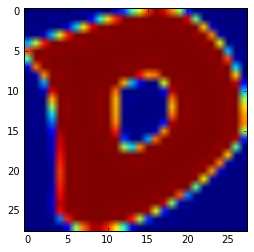

In [23]:
## Plot fifth image of letter D from loaded pickle using imshow

plt.imshow(letter_data[4, :, :])
plt.show()

### Problem 3

In [24]:
## Check if training sets are balanced across letter classes using absolute frequencies

ntrainsets = len(train_data_paths)

train_stats = np.empty(shape=ntrainsets, dtype=np.int64)

for i in np.arange(ntrainsets):
  letter_data = np.load(".".join([train_data_paths[i], "pickle"]))
  train_stats[i] = letter_data.shape[0]

train_stats

array([52909, 52911, 52912, 52911, 52912, 52912, 52912, 52912, 52912, 52911])

In [25]:
## Check if training sets are balanced across letter classes using percentages

train_stats_perc = 100*train_stats/np.float32(sum(train_stats))

train_stats_perc

array([  9.99954641,   9.9999244 ,  10.0001134 ,   9.9999244 ,
        10.0001134 ,  10.0001134 ,  10.0001134 ,  10.0001134 ,
        10.0001134 ,   9.9999244 ])

In [26]:
## Check if test sets are balanced across letter classes using absolute frequencies

ntestsets = len(test_data_paths)

test_stats = np.empty(shape=ntestsets, dtype=np.int64)

for i in np.arange(ntrainsets):
  letter_data = np.load(".".join([test_data_paths[i], "pickle"]))
  test_stats[i] = letter_data.shape[0]

test_stats

array([1872, 1873, 1873, 1873, 1873, 1872, 1872, 1872, 1872, 1872])

In [27]:
## Check if test sets are balanced across letter classes using percentages

test_stats_perc = 100*test_stats/np.float32(sum(test_stats))

test_stats_perc

array([  9.9978637 ,  10.00320444,  10.00320444,  10.00320444,
        10.00320444,   9.9978637 ,   9.9978637 ,   9.9978637 ,
         9.9978637 ,   9.9978637 ])

In [28]:
## Function for allocating array to host all image sub-arrays into it

def allocate_image_space(nimages, image_size):
  if nimages > 0:
    dataset = np.ndarray((nimages, image_size, image_size), dtype=np.float32)
    labels = np.ndarray(nimages, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

In [29]:
## Function for merging letter images into greater arrays to create train, validation and test sets

def merge_images(pickle_files, image_size, ntrain, nvalidation=0):
  train_dataset, train_labels = allocate_image_space(ntrain, image_size)
  validation_dataset, validation_labels = allocate_image_space(nvalidation, image_size)

  nclasses = len(pickle_files)
  ntrain_per_class = ntrain//nclasses
  nvalidation_per_class = nvalidation//nclasses
  total_per_class = ntrain_per_class+nvalidation_per_class
  train_start, validation_start = 0, 0
  train_end, validation_end = ntrain_per_class, nvalidation_per_class

  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_data = pickle.load(f)
        
        # Shuffle the letters to have random training and validation set
        np.random.shuffle(letter_data)

        train_dataset[train_start:train_end, :, :] = letter_data[:ntrain_per_class, :, :]
        train_labels[train_start:train_end] = label
        train_start += ntrain_per_class
        train_end += ntrain_per_class
        
        if validation_dataset is not None:
          validation_dataset[validation_start:validation_end, :, :] = \
            letter_data[ntrain_per_class:total_per_class, :, :]
          validation_labels[validation_start:validation_end] = label
          validation_start += nvalidation_per_class
          validation_end += nvalidation_per_class

    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
        
  return train_dataset, train_labels, validation_dataset, validation_labels

In [30]:
## Set number of train, validation and test images

ntrain = 200000
nvalidation = 10000
ntest = 10000

In [31]:
## Generate train and validation datasets

train_dataset, train_labels, validation_dataset, validation_labels = \
  merge_images(train_files, 28, ntrain, nvalidation)

In [32]:
## Generate test dataset

test_dataset, test_labels, _, _ = merge_images(test_files, 28, ntest)

In [33]:
## Show dimensions of train, validation and test datasets

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', validation_dataset.shape, validation_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

('Training:', (200000, 28, 28), (200000,))
('Validation:', (10000, 28, 28), (10000,))
('Testing:', (10000, 28, 28), (10000,))


In [34]:
## Function for shuffling image datasets

def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation, :, :]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels

In [35]:
## Shuffle train, validation and test datasets

train_dataset, train_labels = randomize(train_dataset, train_labels)
validation_dataset, validation_labels = randomize(validation_dataset, validation_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)

### Problem 4

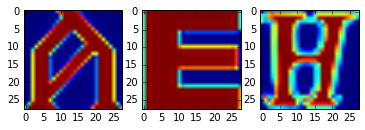

In [36]:
## Display a sample of 3 images in their initial png format

samples = np.random.choice(3, 3, replace=False)

fig = plt.figure()
gs = gridspec.GridSpec(1, 3)
fig.add_subplot(gs[0])
plt.imshow(train_dataset[samples[0], :, :])
fig.add_subplot(gs[1])
plt.imshow(train_dataset[samples[1], :, :])
fig.add_subplot(gs[2])
plt.imshow(train_dataset[samples[2], :, :])
plt.show()

In [37]:
## Count number of letters per class in shuffled train dataset using labels

np.unique(train_labels, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32),
 array([20000, 20000, 20000, 20000, 20000, 20000, 20000, 20000, 20000, 20000]))

In [38]:
## Count number of letters per class in shuffled validation dataset using labels

np.unique(validation_labels, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32),
 array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]))

In [39]:
## Count number of letters per class in shuffled test dataset using labels

np.unique(test_labels, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32),
 array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]))

In [40]:
## Function for saving an object to a pickle file

def save_to_pickle(pickle_file, object, force=False):
  if os.path.exists(pickle_file) and not force:
    print('%s already present, skipping pickling' % pickle_file)
  else:
    try:
      f = open(pickle_file, 'wb')
      pickle.dump(object, f, pickle.HIGHEST_PROTOCOL)
      f.close()
    except Exception as e:
      print('Unable to save object to', pickle_file, ':', e)
      raise      

In [41]:
## Save train, validation and test datasets to pickle file

pickle_file = os.path.join(DATADIR, 'notmnist.pickle')

save_to_pickle(
  pickle_file,
  {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'validation_dataset': validation_dataset,
    'validation_labels': validation_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
  }    
)

/Users/theodore/workspace/self_education/udacity/TensorFlowUdacity/data/notmnist.pickle already present, skipping pickling


In [42]:
## Size of picle file containing train, validation and test datasets

statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

('Compressed pickle size:', 690800451)


### Problem 5

To check whether two images are duplicates it suffices to check if their matrix representations are equal. The main limitation of this approach is that it only detecs exact duplicates. There are other methods for identifying near duplicates.

There are two main classes of methods for detecting near duplicates among images. One of these two method classes is known as image fingerprinting or image hashing. The main idea of image hashing is to construct a unique numerical value, known as image hash, from the contents of the image. The hash plays the role of a fingerprint in the sense that it uniquely identifies its associated image. Images that are “similar” should have “similar” hashes.

Another class of algorithms compares a pair of images by computing a metric of similarity based on the contents of both images. Various similarity metrics are used in practice, such as the mean squared error (MSE) or the structural similarity index (SSIM).

In [43]:
## Function for returning the locations (array indices) of images corresponding to each letter

def get_letter_locations(labels, nclasses):
  n = np.size(labels)
  nperclass = n//nclasses

  locations = np.empty([nclasses, nperclass], dtype=np.int32)
  increments = np.zeros(nclasses, dtype=np.int32)

  for i in np.arange(n):
    locations[labels[i], increments[labels[i]]] = i
    increments[labels[i]] += 1
    
  return locations

In [44]:
## Get the locations of images for each letter in the train, validation and test datasets

train_locations = get_letter_locations(train_labels, 10)
validation_locations = get_letter_locations(validation_labels, 10)
test_locations = get_letter_locations(test_labels, 10)

In [45]:
validation_test_overlap = np.zeros(10, dtype=np.int32)

for i in np.arange(10):
  for j in np.arange(1000):
    for k in np.arange(1000):
      if np.array_equal(train_dataset[validation_locations[i, j]], validation_dataset[test_locations[i, k]]):
        validation_test_overlap[i] += 1

In [46]:
validation_test_overlap

array([ 73, 121,  51,  96, 130, 188, 156,  50, 281,  92], dtype=int32)